# basis Encoding

In [1]:
!pip install qiskit==1.1.0
!pip install qiskit-algorithms
!pip install qiskit-machine-learning
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# Set seed for random generators
algorithm_globals.random_seed = 42
!pip install tensorflow tensorflow_quantum cirq sympy
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512616 sha256=0c370f7c113436cc2d06e3e099c8207bbf5dd853732aa837af63ccf19fc0f496
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c

In [2]:
manual_seed(42)

batch_size = 1
n_samples = 100  # We will concentrate on the first 100 samples

# Use pre-defined torchvision function to load MNIST train data
X_train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_train.targets == 0)[0][:n_samples], np.where(X_train.targets == 1)[0][:n_samples]
)
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5464047.22it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 159963.04it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1513146.68it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8366503.63it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
# Test Dataset
# -------------

# Set test shuffle seed (for reproducibility)
# manual_seed(5)

n_samples = 50

# Use pre-defined torchvision function to load MNIST test data
X_test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_test.targets == 0)[0][:n_samples], np.where(X_test.targets == 1)[0][:n_samples]
)
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

In [4]:
def basis_encoding(data):
    num_qubits = len(data[0])
    feature_map = QuantumCircuit(num_qubits)

    for i, value in enumerate(data[0]):
        if value == 1:
            feature_map.x(i)

    return feature_map

def create_qnn():
    num_qubits = 2  # Adjust this based on your data dimensions

    # Generate a basis encoding circuit with dummy data
    dummy_data = [[1, 0]]  # Example data to determine the number of qubits
    feature_map = basis_encoding(dummy_data)

    ansatz = RealAmplitudes(num_qubits, reps=1)
    qc = QuantumCircuit(num_qubits)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn

qnn4 = create_qnn()


In [44]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN
import torch
import torch.nn.functional as F
from torch.nn import Module, Conv2d, Dropout2d, Linear
from qiskit_machine_learning.connectors import TorchConnector

def basis_encoding(bit_string):
    n = len(bit_string)
    qc = QuantumCircuit(n)
    for i, bit in enumerate(bit_string):
        if bit == 1:
            qc.x(i)
    return qc

def create_qnn():
    num_qubits = 2

    # Create a quantum circuit for the variational part
    qc = QuantumCircuit(num_qubits)

    # Add some variational layers
    params = [Parameter(f'θ{i}') for i in range(num_qubits)]
    for i in range(num_qubits):
        qc.ry(params[i], i)
    qc.cx(0, 1)

    # Define observable for measurement
    observable = SparsePauliOp.from_list([("Z" * num_qubits, 1)])

    # Create the QNN
    qnn = EstimatorQNN(
        circuit=qc,
        observables=observable,
        input_params=params,  # These are now input parameters again
        weight_params=[],  # No separate weight parameters
    )
    return qnn

qnn4 = create_qnn()

class Net(Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 2)  # 2-dimensional output for basis encoding
        self.qnn = TorchConnector(qnn)
        self.fc3 = Linear(1, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # Convert to binary for basis encoding
        x = (x > 0).float()
        # The QNN now directly takes the binary tensor
        x = self.qnn(x)  # Apply QNN
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

model4 = Net(qnn4)

In [45]:
optimizer = optim.Adam(model4.parameters(), lr=0.001)
loss_func = NLLLoss()
accuracy_list = []

# Start training
epochs = 10  # Set number of epochs
loss_list = []  # Store loss history
model4.train()  # Set model to training mode

for epoch in range(epochs):
    correct_predictions = 0
    total_predictions = 0
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model4(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        _, predicted = torch.max(output, 1)
        correct_predictions += (predicted == target).sum().item()
        total_predictions += target.size(0)
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    accuracy = correct_predictions / total_predictions
    accuracy_list.append(accuracy)
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))


Training [10%]	Loss: 0.7388
Training [20%]	Loss: 0.7191
Training [30%]	Loss: 0.7078
Training [40%]	Loss: 0.7013
Training [50%]	Loss: 0.6980
Training [60%]	Loss: 0.6960
Training [70%]	Loss: 0.6952
Training [80%]	Loss: 0.6943
Training [90%]	Loss: 0.6942
Training [100%]	Loss: 0.6940


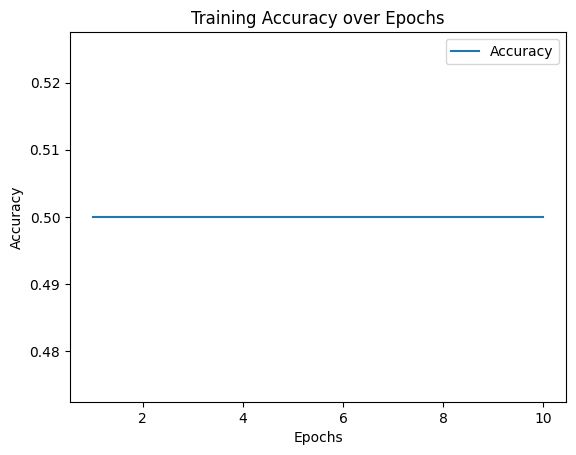

In [46]:
plt.plot(range(1, epochs + 1), accuracy_list, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()
plt.show()

#RX Parameterized Rotation Encoding

In [7]:
from qiskit.circuit import ParameterVector

def basis_encoding(data): #actually parameterised encoding
    num_qubits = len(data[0])
    feature_map = QuantumCircuit(num_qubits)
    parameters = ParameterVector('x', num_qubits)

    for i in range(num_qubits):
        feature_map.rx(parameters[i], i)

    return feature_map, parameters


In [8]:
def create_qnn():
    num_qubits = 2  # Adjust this based on your data dimensions

    # Generate a basis encoding circuit with dummy data
    dummy_data = [[1, 0]]  # Example data to determine the number of qubits
    feature_map, input_params = basis_encoding(dummy_data)

    ansatz = RealAmplitudes(num_qubits, reps=1)
    qc = QuantumCircuit(num_qubits)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=input_params,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn

qnn4 = create_qnn()


In [9]:
import torch
import torch.nn.functional as F
from torch.nn import Module, Conv2d, Dropout2d, Linear
from torch.utils.data import DataLoader
from qiskit_machine_learning.connectors import TorchConnector

class Net(Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 2)  # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        # uniformly at random from interval [-1,1].
        self.fc3 = Linear(1, 2)  # 2-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

model4 = Net(qnn4)


Training [10%]	Loss: 0.1386
Training [20%]	Loss: 0.1288
Training [30%]	Loss: 0.0933
Training [40%]	Loss: 0.0809
Training [50%]	Loss: 0.0531
Training [60%]	Loss: 0.0435
Training [70%]	Loss: 0.0453
Training [80%]	Loss: 0.0266
Training [90%]	Loss: 0.0210
Training [100%]	Loss: 0.0178


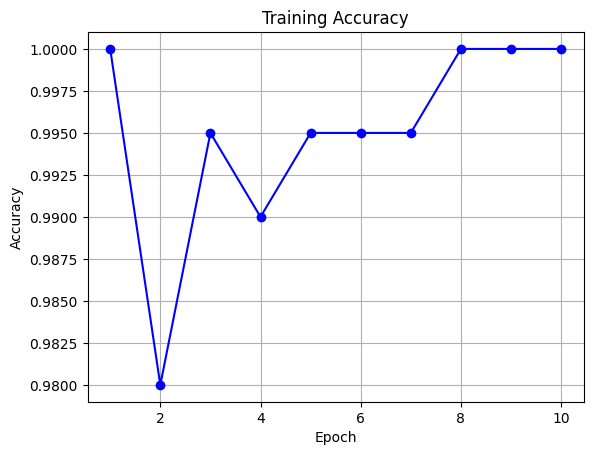

In [13]:
import torch.optim as optim
from torch.nn import NLLLoss
from torchvision import datasets, transforms
import numpy as np

# Load and preprocess the MNIST dataset
manual_seed = 42
batch_size = 1
n_samples = 100  # We will concentrate on the first 100 samples

# Use pre-defined torchvision function to load MNIST train data
X_train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_train.targets == 0)[0][:n_samples], np.where(X_train.targets == 1)[0][:n_samples]
)
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

# Test Dataset
# Use pre-defined torchvision function to load MNIST test data
X_test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_test.targets == 0)[0][:n_samples], np.where(X_test.targets == 1)[0][:n_samples]
)
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

# Define optimizer and loss function
optimizer = optim.Adam(model4.parameters(), lr=0.001)
loss_func = NLLLoss()
accuracy_list = []

# Start training
epochs = 10  # Set number of epochs
loss_list = []  # Store loss history
model4.train()  # Set model to training mode

for epoch in range(epochs):
    correct_predictions = 0
    total_predictions = 0
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model4(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        _, predicted = torch.max(output, 1)
        correct_predictions += (predicted == target).sum().item()
        total_predictions += target.size(0)
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    accuracy = correct_predictions / total_predictions
    accuracy_list.append(accuracy)
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))
plt.plot(range(1, epochs + 1), accuracy_list, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.grid(True)
plt.show()


#RY Parameterized Rotation Encoding

In [25]:
#To change the parameterized encoding from `rx` to `ry`, you need to replace the `rx` gates with `ry` gates in the `basis_encoding` function. Here is the modified code:


from qiskit.circuit import ParameterVector, QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
from qiskit_machine_learning.neural_networks import EstimatorQNN

def basis_encoding(data): # actually parameterised encoding
    num_qubits = len(data[0])
    feature_map = QuantumCircuit(num_qubits)
    parameters = ParameterVector('x', num_qubits)

    for i in range(num_qubits):
        feature_map.ry(parameters[i], i)

    return feature_map, parameters

def create_qnn():
    num_qubits = 2  # Adjust this based on your data dimensions

    # Generate a basis encoding circuit with dummy data
    dummy_data = [[1, 0]]  # Example data to determine the number of qubits
    feature_map, input_params = basis_encoding(dummy_data)

    ansatz = RealAmplitudes(num_qubits, reps=1)
    qc = QuantumCircuit(num_qubits)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=input_params,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn

qnn4 = create_qnn()

import torch
import torch.nn.functional as F
from torch.nn import Module, Conv2d, Dropout2d, Linear
from torch.utils.data import DataLoader
from qiskit_machine_learning.connectors import TorchConnector

class Net(Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 2)  # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        # uniformly at random from interval [-1,1].
        self.fc3 = Linear(1, 2)  # 2-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

model4 = Net(qnn4)


Training [10%]	Loss: 0.4860
Training [20%]	Loss: 0.2779
Training [30%]	Loss: 0.1995
Training [40%]	Loss: 0.1503
Training [50%]	Loss: 0.1272
Training [60%]	Loss: 0.0965
Training [70%]	Loss: 0.0732
Training [80%]	Loss: 0.0594
Training [90%]	Loss: 0.0557
Training [100%]	Loss: 0.0440


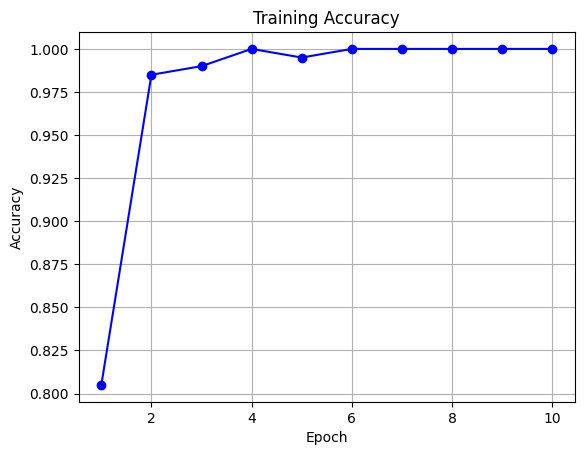

In [26]:
import torch.optim as optim
from torch.nn import NLLLoss
from torchvision import datasets, transforms
import numpy as np

# Load and preprocess the MNIST dataset
manual_seed = 42
batch_size = 1
n_samples = 100  # We will concentrate on the first 100 samples

# Use pre-defined torchvision function to load MNIST train data
X_train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_train.targets == 0)[0][:n_samples], np.where(X_train.targets == 1)[0][:n_samples]
)
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

# Test Dataset
# Use pre-defined torchvision function to load MNIST test data
X_test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_test.targets == 0)[0][:n_samples], np.where(X_test.targets == 1)[0][:n_samples]
)
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

# Define optimizer and loss function
optimizer = optim.Adam(model4.parameters(), lr=0.001)
loss_func = NLLLoss()
accuracy_list = []

# Start training
epochs = 10  # Set number of epochs
loss_list = []  # Store loss history
model4.train()  # Set model to training mode

for epoch in range(epochs):
    correct_predictions = 0
    total_predictions = 0
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model4(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        _, predicted = torch.max(output, 1)
        correct_predictions += (predicted == target).sum().item()
        total_predictions += target.size(0)
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    accuracy = correct_predictions / total_predictions
    accuracy_list.append(accuracy)
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))
plt.plot(range(1, epochs + 1), accuracy_list, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.grid(True)
plt.show()


# RZ Parameterized Rotation Encoding

In [27]:
from qiskit.circuit import ParameterVector, QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
from qiskit_machine_learning.neural_networks import EstimatorQNN

def basis_encoding(data): # actually parameterised encoding
    num_qubits = len(data[0])
    feature_map = QuantumCircuit(num_qubits)
    parameters = ParameterVector('x', num_qubits)

    for i in range(num_qubits):
        feature_map.rz(parameters[i], i)

    return feature_map, parameters

def create_qnn():
    num_qubits = 2  # Adjust this based on your data dimensions

    # Generate a basis encoding circuit with dummy data
    dummy_data = [[1, 0]]  # Example data to determine the number of qubits
    feature_map, input_params = basis_encoding(dummy_data)

    ansatz = RealAmplitudes(num_qubits, reps=1)
    qc = QuantumCircuit(num_qubits)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=input_params,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn

qnn4 = create_qnn()

import torch
import torch.nn.functional as F
from torch.nn import Module, Conv2d, Dropout2d, Linear
from torch.utils.data import DataLoader
from qiskit_machine_learning.connectors import TorchConnector

class Net(Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 2)  # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        # uniformly at random from interval [-1,1].
        self.fc3 = Linear(1, 2)  # 2-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

model4 = Net(qnn4)


Training [10%]	Loss: 0.7015
Training [20%]	Loss: 0.6971
Training [30%]	Loss: 0.6951
Training [40%]	Loss: 0.6947
Training [50%]	Loss: 0.6946
Training [60%]	Loss: 0.6941
Training [70%]	Loss: 0.6942
Training [80%]	Loss: 0.6943
Training [90%]	Loss: 0.6941
Training [100%]	Loss: 0.6940


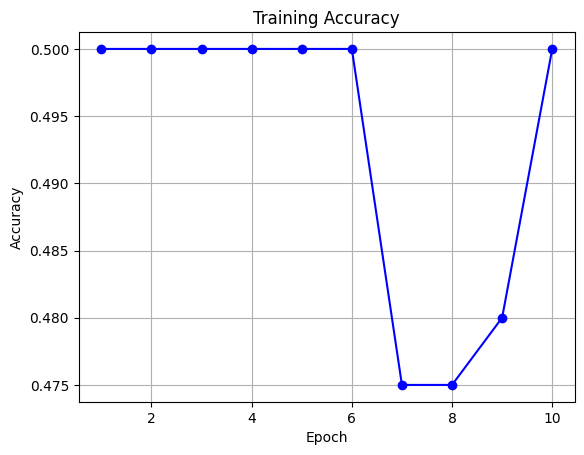

In [28]:
import torch.optim as optim
from torch.nn import NLLLoss
from torchvision import datasets, transforms
import numpy as np

# Load and preprocess the MNIST dataset
manual_seed = 42
batch_size = 1
n_samples = 100  # We will concentrate on the first 100 samples

# Use pre-defined torchvision function to load MNIST train data
X_train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_train.targets == 0)[0][:n_samples], np.where(X_train.targets == 1)[0][:n_samples]
)
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

# Test Dataset
# Use pre-defined torchvision function to load MNIST test data
X_test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_test.targets == 0)[0][:n_samples], np.where(X_test.targets == 1)[0][:n_samples]
)
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

# Define optimizer and loss function
optimizer = optim.Adam(model4.parameters(), lr=0.001)
loss_func = NLLLoss()
accuracy_list = []

# Start training
epochs = 10  # Set number of epochs
loss_list = []  # Store loss history
model4.train()  # Set model to training mode

for epoch in range(epochs):
    correct_predictions = 0
    total_predictions = 0
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model4(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        _, predicted = torch.max(output, 1)
        correct_predictions += (predicted == target).sum().item()
        total_predictions += target.size(0)
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    accuracy = correct_predictions / total_predictions
    accuracy_list.append(accuracy)
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))
plt.plot(range(1, epochs + 1), accuracy_list, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.grid(True)
plt.show()
